# ResNet-UNet Model

We conduct experiments on a U-Net model where the down-sampling encoder is replaced by different ResNet models.



In [1]:
import os
from glob import glob
import torch

from src_notebooks.utils import *
from src_notebooks.models import ResNet18UNet, ResNet50UNet, ResNet152UNet
from src_notebooks.pytorch_utils import *
from src_notebooks.dataset_augmentation import augment_dataset

### Setup

This notebook builds upon the *unet_baseline.ipynb* notebook. If you ran it before, feel free to skip the next code cell. Otherwise, execute it to generate an extended dataset using augmentation methods.

In [ ]:
augment_dataset(
    imgs=load_pil_images(os.path.join("training", "images")), 
    masks=load_pil_images(os.path.join("training", "groundtruth")),
    n_samples_per_img=10,
    dir="training_ext",
    brightness=0.1, 
    contrast=0.1, 
    saturation=0.1, 
    hue=0.05
)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# get filenames of all the training samples from the extended dataset
image_fns = sorted(glob(os.path.join("training_ext", "images", "*.png")))
mask_fns = sorted(glob(os.path.join("training_ext", "groundtruth", "*.png")))

### Transfer Learning
As a first step, we show the effect of transfer learning by training the model with/without weights that are pretrained on the ImageNet dataset. For that, let us use the ResNet-18 model.

In [ ]:
# without pretrained weights
resnet_unet = ResNet18UNet().to(device)
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns[:-100],
    mask_fns_train=mask_fns[:-100],
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=35,
    batch_size=4,
    resize_shape=(384, 384),
    normalize=True,
)

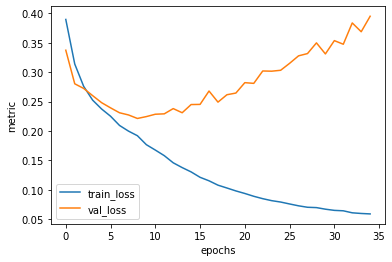

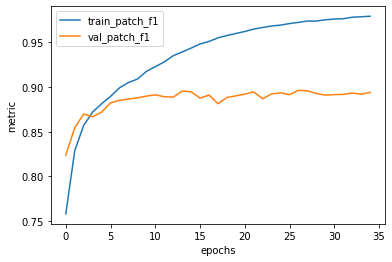

In [4]:
plot_training_history(history)

In [ ]:
# with pretrained weights
resnet_unet = ResNet18UNet(pretrained=True).to(device)
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns[:-100],
    mask_fns_train=mask_fns[:-100],
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=35,
    batch_size=4,
    resize_shape=(384, 384),
    normalize=True,
)

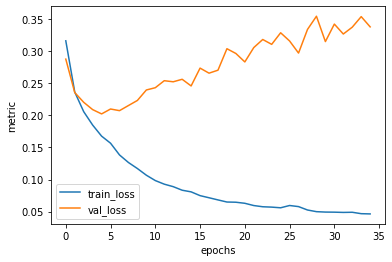

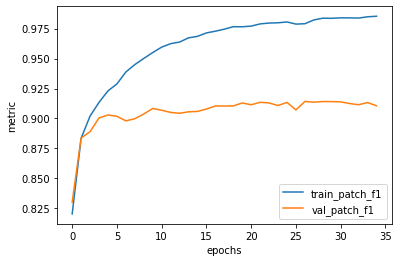

In [6]:
plot_training_history(history)

In [ ]:
preds = predict_on_test_set(
    resnet_unet, 
    resize_shape=(384, 384), 
    normalize=True, 
    submission_fn="resnet18_unet.csv")
plot_predictions(preds)

We can see that the use of pretrained weights has a slight advantage in terms of patch F1 score. We can again observe the patch F1 score keep increasing slightly even once the model starts to overfit after epoch 5. The overfitting seems to be mostly making the road segmentations more crispy, which is not harmful (or is even slightly beneficial) once we divide the image into patches to compute the F1 score.

On the public leaderboard, we get a score of about 0.905, a slight improvement over the improved U-Net baseline model.

### Other ResNet Versions
Let us try out other ResNet models for the down-sampling encoder part of the U-Net model such as the ResNet-50 and ResNet-152.

In [ ]:
resnet_unet = ResNet50UNet(pretrained=True).to(device)
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns[:-100],
    mask_fns_train=mask_fns[:-100],
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=35,
    batch_size=4,
    resize_shape=(384, 384),
    normalize=True,
)

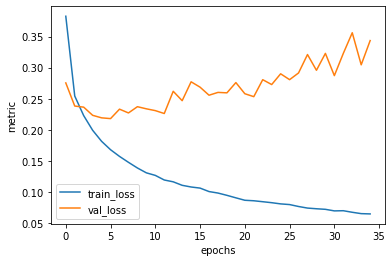

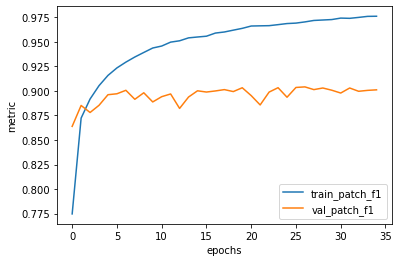

In [4]:
plot_training_history(history)

In [ ]:
resnet_unet = ResNet152UNet(pretrained=True).to(device)
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns[:-100],
    mask_fns_train=mask_fns[:-100],
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=35,
    batch_size=4,
    resize_shape=(384, 384),
    normalize=True,
)

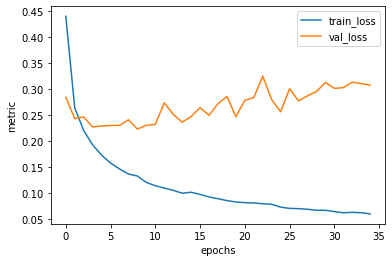

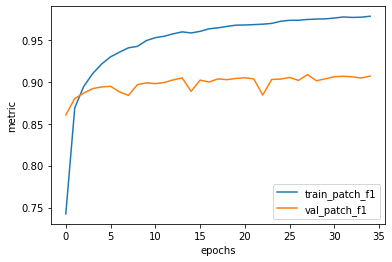

In [4]:
plot_training_history(history)

Unfortunately, the metric histoies show no clear improvement with respect to the patch F1 score.